In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals, inv
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, Matern
from GP import GaussianProcessRegressor

In [224]:
datasets = 1
n = 8
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

x = np.zeros(N)                 # All x
y = np.zeros(N)                 # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = (0.5-np.random.rand(n) + energies)                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        x[index] = energies[j]
        y[index] = values[j]
        total_errors[index] = s[j] 
    dataset_sizes[i] = n

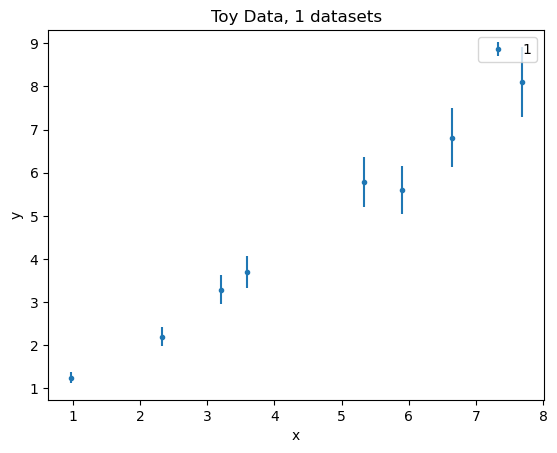

<Figure size 640x480 with 0 Axes>

In [225]:
# Plot the model data

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'Toy Data, {datasets} datasets')
plt.show()
plt.clf()

In [226]:
magnitude = 1                             # Initial values for kernel hyperparameters, which get set by extremizing the log-likelihood
length_scale = 1
#kernel =  ConstantKernel(magnitude) *RBF(length_scale) 
#kernel = ConstantKernel(magnitude) * RBF(length_scale) * DotProduct(1)
kernel = ConstantKernel(magnitude) * Matern(length_scale, nu=2.5)
num_test = 300
x_test = np.linspace(0.5, n+0.5, num_test)

uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total=total_errors)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_theta = uncorrelated_gp.get_hyperparameter_values()

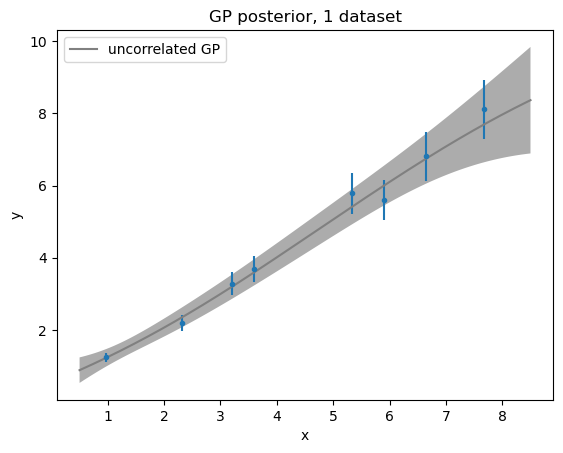

In [227]:
# Plot posterior

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'GP posterior, {datasets} dataset')
plt.show()

In [230]:
#percent_correlations = np.linspace(0,1,6)          # Percent of total error that is correlated with other data points
percent_correlations = [0.0,0.5,0.8,1]

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    print(round(percent,1))
    print(correlated_gp.get_hyperparameter_values())
    print(eigvals(correlated_K11))
    #print(inv(correlated_K11))
    print()


0.0
[65.33538248 15.47039983]
[5.07480748e+02+0.j 1.52781225e+01+0.j 7.95743949e-01+0.j
 4.61974200e-01+0.j 5.85229287e-02+0.j 1.20509063e-01+0.j
 2.38673712e-01+0.j 3.26278239e-01+0.j]

0.5
[66.65072214 15.85503191]
[5.18751814e+02+0.j 1.49404204e+01+0.j 6.66364610e-01+0.j
 3.52965838e-01+0.j 4.49997682e-02+0.j 9.07802464e-02+0.j
 1.90201261e-01+0.j 2.45743606e-01+0.j]

0.8
[66.0216945  16.36630252]
[5.15275471e+02+0.j 1.40291279e+01+0.j 4.74893176e-01+0.j
 1.77678717e-01+0.j 2.32945415e-02+0.j 4.41039128e-02+0.j
 1.06140971e-01+0.j 1.20358345e-01+0.j]

1
[1.e-05 1.e+05]
[2.07757775e+00+0.00000000e+00j 1.50721714e-05+0.00000000e+00j
 1.00000733e-10+0.00000000e+00j 1.00000073e-10+0.00000000e+00j
 1.00000023e-10+0.00000000e+00j 9.99999722e-11+2.35272434e-18j
 9.99999722e-11-2.35272434e-18j 1.00000002e-10+0.00000000e+00j]



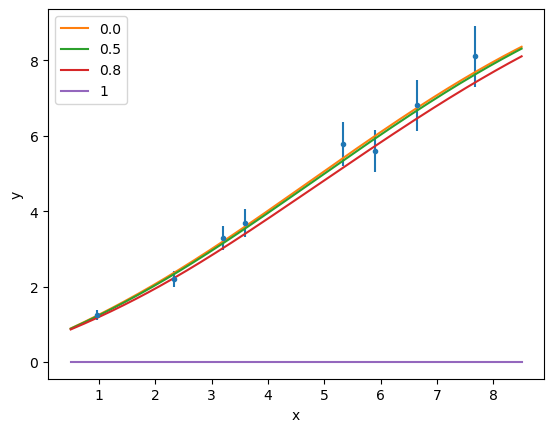

In [229]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_mean, label=str(round(percent,2)))
    #plt.fill_between(x_test, correlated_mean - uncorrelated_std, correlated_mean + uncorrelated_std, alpha=0.65, edgecolor='none')

plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.show()


What happens if the kernel hyperparameters are fixed by the uncorrelated case?

In [241]:
uncorrelated_theta = [15,3]

#fixed_kernel = ConstantKernel(uncorrelated_theta[0], constant_value_bounds='fixed') * RBF(uncorrelated_theta[1], length_scale_bounds='fixed') 
fixed_kernel = ConstantKernel(uncorrelated_theta[0], constant_value_bounds='fixed') * Matern(uncorrelated_theta[1], length_scale_bounds='fixed') 

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    print(round(percent,1))
    print(eigvals(correlated_K11))
    #print(correlated_K11)
    print()


0.0
[75.73171206+0.j 30.1024153 +0.j  8.59122312+0.j  4.60134417+0.j
  1.36605101+0.j  0.97324137+0.j  0.21702349+0.j  0.4945023 +0.j]

0.5
[76.09113286+0.j 30.11681832+0.j  8.53598982+0.j  4.52667097+0.j
  1.28503125+0.j  0.9236483 +0.j  0.18795518+0.j  0.41026612+0.j]

0.8
[76.65378084+0.j 30.13761948+0.j  8.45180765+0.j  4.40881891+0.j
  1.18148521+0.j  0.82434813+0.j  0.14179704+0.j  0.27785556+0.j]

1
[77.1751971 +0.j 30.15507285+0.j  8.37619807+0.j  4.29860798+0.j
  1.11049702+0.j  0.7092202 +0.j  0.09614581+0.j  0.1565738 +0.j]



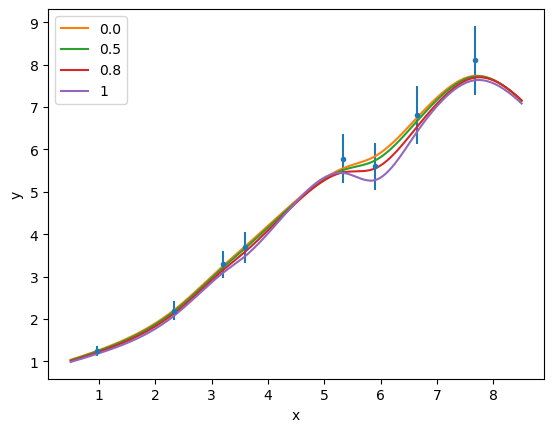

In [242]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

for percent in percent_correlations:
    systematic_errors = percent * total_errors
    correlated_gp = GaussianProcessRegressor(kernel=fixed_kernel)
    correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
    correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
    plt.plot(x_test, correlated_mean, label=str(round(percent,2)))
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.show()